<a href="https://colab.research.google.com/github/asriva13/PINN/blob/main/2D_heat_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs
! apt-get update
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt install cm-super
! pip install dmsh
! pip install optimesh

In [ ]:
#@title Imports
%matplotlib inline
import jax.numpy as np
import numpy
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import jacfwd, jacrev
from jax.numpy import linalg
from jax.example_libraries import optimizers


# This import registers the 3D projection, but is otherwise unused.
#from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import LogNorm
import scipy as sc
from mpl_toolkits.axes_grid1 import ImageGrid
import string
import dmsh
import meshio
import optimesh
import meshplex
from numpy import loadtxt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
#%matplotlib inline

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

key = random.PRNGKey(0)

In [ ]:
#@title Functions
##################
#Definitions relevant to NN architecture.
########################
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

def ReLU2(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return (np.maximum(0, np.sign(x)*x**2))

def ReLU3(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return (np.maximum(0, x**3))

def rbf(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.exp(-x**2)

def sigmoid(x):
    return 1./(1. + np.exp(-x))

def tanh(x):
    return 2.*sigmoid(2*x)-1.

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def relu2_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU2(np.dot(params[0], x) + params[1])

def rbf_layer(params, x):
    """ Simple ReLu layer for single sample """
    return rbf(np.dot(params[0], x)/ params[1])

def relu3_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU3(np.dot(params[0], x) + params[1])


def sigmoid_layer(params, x):
    """ Simple ReLu layer for single sample """
    return sigmoid(np.dot(params[0], x) + params[1])

def tanh_layer(params, x):
    """ Simple ReLu layer for single sample """
    return tanh(np.dot(params[0], x) + params[1])

############################
############################


###########################
#####Data reshape

def datareshapeMLP(x,numBatches):
  #numpy.random.shuffle(x)
  if numBatches>1:
    l=len(x)
    numCol=int(l/numBatches)
    x=x[:l*numCol]
    x=x.reshape(numBatches,numCol)
  else:
    x=x.reshape(1,len(x))

  return x


############################
###Initialize weights for an MLP
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1.e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

############################

def polygon(points,o=0):
  l = len(points[:,0])
  segments = numpy.zeros((l,4))
  for i in range(l-1):
    segments[i,:2]=points[i,:]
    segments[i,2:4]=points[i+1,:]
  i = i+1
  segments[i,:2]=points[i,:]
  segments[i,2:4]=points[0,:]  

  if o==0:
    return segments
  else:
    return numpy.flip(segments,axis=0)

############################
############################
def run_training(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = update(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er


def error(params, x, y):
    ex = e_vect(x,y)
    e = u_vect(params,x,y) - e_vect(x,y)
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

###########################


def NN(params, x, y):
    """ Compute the forward pass for each example individually """
    activations = np.array([x,y])

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu3_layer([w, b], activations)

    final_w, final_b = params[-1]
    final = np.sum(np.dot(final_w, activations)) + final_b

    return (final[0])

def NNRBF(params, x, y):
    """ Compute the forward pass for each example individually """
    activations = np.array([x,y])

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = rbf_layer([w, b], activations)

    final_w, final_b = params[-1]
    final = np.sum(np.dot(final_w, activations)) #+ final_b

    return (final[0])


#################R functions and MVC

def dist(x1,y1,x2,y2):
  return np.sqrt((x2-x1)**2+(y2-y1)**2)

def linseg(x,y,x1,y1,x2,y2):
  L=dist(x1,y1,x2,y2)
  xc = (x1+x2)/2.
  yc = (y1+y2)/2.
  f = (1/L)*((x-x1)*(y2-y1) - (y-y1)*(x2-x1))
  t = (1/L)*((L/2.)**2-dist(x,y,xc,yc)**2)
  phi = np.sqrt(t**2+f**4)

  return np.sqrt(f**2 + (1/4.)*(phi - t)**2)

def R_eq(rho1,rho2,m=1):
  return rho1*rho2/((rho1**m + rho2**m)**(1/m))

def phi(x,y,segments):
  m = 1.
  # R = 1.
  R = 0.
  for i in range(len(segments[:,0])):
    rho = linseg(x,y,segments[i,0],segments[i,1],segments[i,2],segments[i,3])
    # R = R_eq(R,rho,m)
    R = R + 1./rho**m
  R = 1/R**(1/m)

  return R

def tanaby2(r1,r2):
  return np.linalg.norm(np.cross(r1,r2))/(np.linalg.norm(r1)*np.linalg.norm(r2) + np.dot(r1,r2))

def meanValue(x,y,segments):

  p = 1.

  W = 0.
  i = len(segments[:,0])-1
  a1,b1 = segments[i,0]-x,segments[i,1]-y
  a2,b2 = segments[0,0]-x,segments[0,1]-y
  a3,b3 = segments[0,2]-x,segments[0,3]-y
  tm1 = abs(a1*b2-a2*b1)/(dist(a1,b1,0.,0.)*dist(a2,b2,0.,0.) + a1*a2 + b1*b2)
  t = abs(a2*b3-a3*b2)/(dist(a2,b2,0.,0.)*dist(a3,b3,0.,0.) + a2*a3 + b2*b3)
  w = (t + tm1)/dist(a2,b2,0.,0.)
  W = W + w**p

  for j in range(len(segments[:,0])-1):
    i=j+1
    a1,b1 = segments[j,0]-x,segments[j,1]-y
    a2,b2 = segments[i,0]-x,segments[i,1]-y
    a3,b3 = segments[i,2]-x,segments[i,3]-y
    tm1 = abs(a1*b2-a2*b1)/(dist(a1,b1,0.,0.)*dist(a2,b2,0.,0.) + a1*a2 + b1*b2)
    t = abs(a2*b3-a3*b2)/(dist(a2,b2,0.,0.)*dist(a3,b3,0.,0.) + a2*a3 + b2*b3)
    w = (t + tm1)/dist(a2,b2,0.,0.)
    W = W + w**p

  return 1./W**(1/p)

def g(x,y,segments):
  mu = 1.
  R = 0.
  for i in range(len(segments[:,0])):
    rho = linseg(x,y,segments[i,0],segments[i,1],segments[i,2],segments[i,3])
    R = R + rho**(-mu)

  w3 = (linseg(x,y,segments[2,0],segments[2,1],segments[2,2],segments[2,3]))**(-mu)/R
  g = np.sin(np.pi*x)*w3

  return g


gxx = grad(grad(g,0),0) 
gyy = grad(grad(g,1),1)
phixx = grad(grad(phi,0),0) 
phix = grad(phi,0) 
phiyy = grad(grad(phi,1),1)
meanValuexx = grad(grad(meanValue,0),0)
meanValueyy = grad(grad(meanValue,1),1)

g_vect = vmap(g, (0, 0, None))
gxx_vect = vmap(gxx, (0, 0, None))
gyy_vect = vmap(gyy, (0, 0, None))
R_vect = vmap(phi, (0, 0, None))
phix_vect = vmap(phix, (0, 0, None))
phixx_vect = vmap(phixx, (0, 0, None))
phiyy_vect = vmap(phiyy, (0, 0, None))
meanValue_vect = vmap(meanValue, (0, 0, None))
meanValuexx_vect = vmap(meanValuexx, (0, 0, None))
meanValueyy_vect = vmap(meanValueyy, (0, 0, None))
#####################

def gridValues(x,y,z):
  l = int(numpy.sqrt(len(x)))
  grid_x, grid_y = numpy.mgrid[min(x):max(x):l*1j, min(y):max(y):l*1j]
  values = z.reshape((l,l))
  return grid_x.T,grid_y.T,values


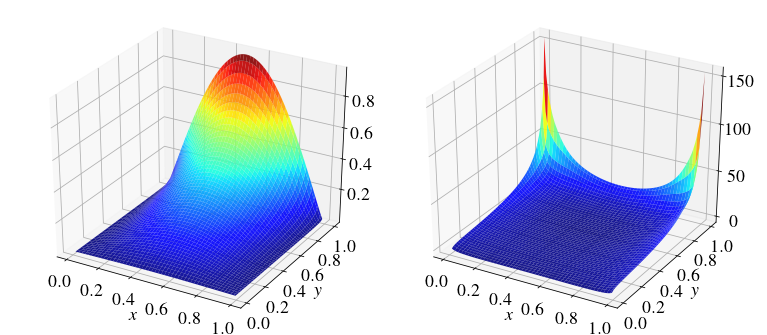

In [ ]:
#@title g function and its Laplacian. Domain square, sine on one end

#Domain boundary
ax,bx = 0.,1.
ay,by = 0.,1.

segments = np.array([[0.,0.,1.,0.],[1.,0.,1.,1.],[1.,1.,0.,1.],[0.,1.,0.,0.]])

dx = 0.01
x = numpy.linspace(ax+dx, bx-dx, num=100)
y = numpy.linspace(ay+dx, by-dx, num=100)
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()


x = numpy.linspace(.01, .99, num=100)
y = numpy.linspace(.01, .99, num=100)
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()


###################################
layer_sizes = [2, 50, 50, 1]
#R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uR(params, x, y):
    return phi(x,y,segments)*NN(params,x,y)+g(x,y,segments)

def lossR(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y)
    return np.mean(eq**2)

grad1 = grad(grad(uR,1),1)
grad2 = grad(grad(uR,2),2)
d2udx2R_vect = vmap(grad1, (None, 0, 0))
d2udy2R_vect = vmap(grad2, (None, 0, 0))
uR_vect = vmap(uR, (None, 0, 0))


###################################
#Dirichlet Mean value

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uM(params, x, y):
    return meanValue(x,y,segments)*NN(params,x,y)+g(x,y,segments)

def lossM(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y)
    return np.mean(eq**2)

grad1 = grad(grad(uM,1),1)
grad2 = grad(grad(uM,2),2)
d2udx2M_vect = vmap(grad1, (None, 0, 0))
d2udy2M_vect = vmap(grad2, (None, 0, 0))
uM_vect = vmap(uM, (None, 0, 0))



plt.rcParams.update({'font.size': 18})
######
#Plots

fig = plt.figure(figsize=(11, 5))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.)
# gs.update(hspace=.25)
ax1 = plt.subplot(gs[0, 0], projection = '3d')
ax2 = plt.subplot(gs[0, 1], projection = '3d')
# ax3 = plt.subplot(gs[0, 2], projection = '3d')
# ax4 = plt.subplot(gs[0, 3], projection = '3d')



# X,Y,Z = gridValues(x,y,exactSoln1)
a = numpy.array(g_vect(x, y, segments))
# b = numpy.array(meanValue_vect(x, y, segments))
b = numpy.array(gxx_vect(x, y, segments) + gyy_vect(x, y, segments))
# d = numpy.array(meanValuexx_vect(x, y, segments) + meanValueyy_vect(x, y, segments))

X,Y,A = gridValues(x,y,a)
X,Y,B = gridValues(x,y,b)
# X,Y,C = gridValues(x,y,c)
# X,Y,D = gridValues(x,y,d)

ax1.plot_surface(X, Y, A, cmap=plt.cm.jet, alpha=0.9)
ax2.plot_surface(X, Y, B, cmap=plt.cm.jet, alpha=0.9)
# ax3.plot_surface(X, Y, C, cmap=plt.cm.Spectral)
# ax4.plot_surface(X, Y, D, cmap=plt.cm.Spectral)

# ax1.set_title('$g(\mathbf{x})$')
# ax2.set_title('$\\nabla^2 g(\mathbf{x})$')
# ax3.set_title('$\\nabla^2 \phi_R$')
# ax4.set_title('$\\nabla^2 \phi_M$')

ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
# ax3.set_xlabel('$x$')
# ax3.set_ylabel('$y$')
# ax4.set_xlabel('$x$')
# ax4.set_ylabel('$y$')

# ax1.dist = 11

ax1.locator_params(nbins=6)
ax2.locator_params(nbins=6)

plt.tight_layout()
fig.savefig('Heat-Laplacian-g.pdf', format='pdf')

plt.show()

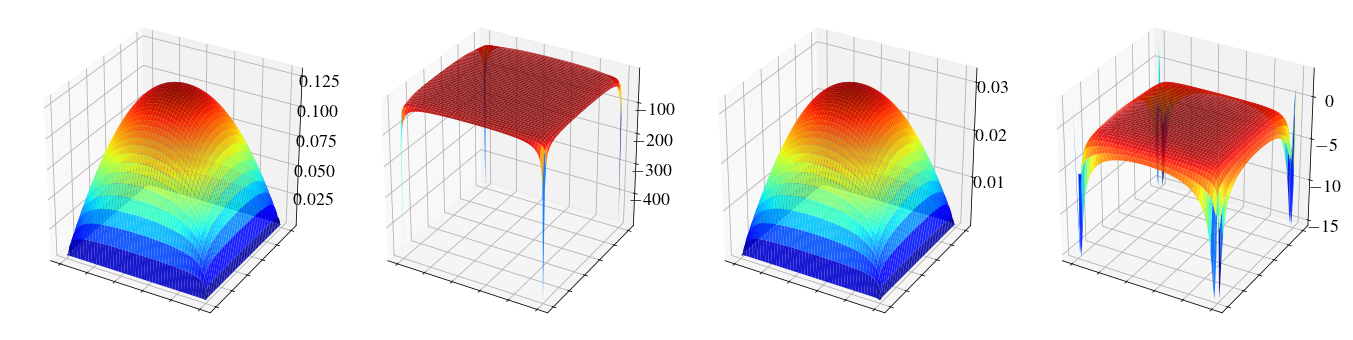

In [ ]:
#@title Laplacian of the ADF
#Domain boundary
ax,bx = 0.,1.
ay,by = 0.,1.

segments = np.array([[0.,0.,1.,0.],[1.,0.,1.,1.],[1.,1.,0.,1.],[0.,1.,0.,0.]])

dx = 0.001
x = numpy.linspace(ax+dx, bx-dx, num=100)
y = numpy.linspace(ay+dx, by-dx, num=100)
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()


phixx = grad(grad(phi,0),0) 
phiyy = grad(grad(phi,1),1)

phixx_vect = vmap(phixx, (0, 0, None))
phiyy_vect = vmap(phiyy, (0, 0, None))


# def phi(x,y,segments):
#   m = 1.
#   # R = 1.
#   R = 0.
#   for i in range(len(segments[:,0])):
#     rho = linseg(x,y,segments[i,0],segments[i,1],segments[i,2],segments[i,3])
#     # R = R_eq(R,rho,m)
#     R = R + 1./rho**m
#   R = 1/R**(1/m)

#   return R

def phit(x, y, segments):
    N=2
    P=1000
    ver=R_eq(R_eq(R_eq(tanh(P*dist(x,y,0,0)**N),tanh(P*dist(x,y,0,1)**N),1),tanh(P*dist(x,y,1,1)**N),1),tanh(P*dist(x,y,1,0)**N),1)
    #Uncomment below to revert back to the usual phi
    # ver=1
    return ver*phi(x,y,segments)


phixxt = grad(grad(phit,0),0) 
phiyyt = grad(grad(phit,1),1)

phixxt_vect = vmap(phixxt, (0, 0, None))
phiyyt_vect = vmap(phiyyt, (0, 0, None))

phit_vect = vmap(phit, (0, 0, None))

plt.rcParams.update({'font.size': 18})
######
#Plots

fig = plt.figure(figsize=(24, 6))
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=0.03)
ax1 = plt.subplot(gs[0, 0], projection = '3d')
ax2 = plt.subplot(gs[0, 1], projection = '3d')
ax3 = plt.subplot(gs[0, 2], projection = '3d')
ax4 = plt.subplot(gs[0, 3], projection = '3d')


a = numpy.array(R_vect(x, y, segments))
b = numpy.array(phixx_vect(x, y, segments) + phiyy_vect(x, y, segments))
c = numpy.array(phit_vect(x, y, segments))
d = numpy.array(phixxt_vect(x, y, segments) + phiyyt_vect(x, y, segments))

X,Y,A = gridValues(x,y,a)
X,Y,B = gridValues(x,y,b)
X,Y,C = gridValues(x,y,c)
X,Y,D = gridValues(x,y,d)

ax1.plot_surface(X, Y, A, cmap=plt.cm.jet, alpha=0.9)
ax2.plot_surface(X, Y, B, cmap=plt.cm.jet, alpha=0.9)
ax3.plot_surface(X, Y, C, cmap=plt.cm.jet, alpha=0.9)
ax4.plot_surface(X, Y, D, cmap=plt.cm.jet, alpha=0.9)
# ax3.plot_surface(X, Y, C, cmap=plt.cm.jet, alpha=0.9)
# ax4.plot_surface(X, Y, D, cmap=plt.cm.jet, alpha=0.9)

# ax1.set_zlabel('$\\phi$')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
# ax1.set_zticklabels([])

# ax2.set_zlabel('$\\nabla^2\\phi$')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
# ax2.set_zticklabels([])

ax3.set_xticklabels([])
ax3.set_yticklabels([])

ax4.set_xticklabels([])
ax4.set_yticklabels([])

# plt.tight_layout()
# fig.savefig('Heat-Laplacian.pdf', format='pdf')
fig.savefig('Laplacian.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)

plt.show()

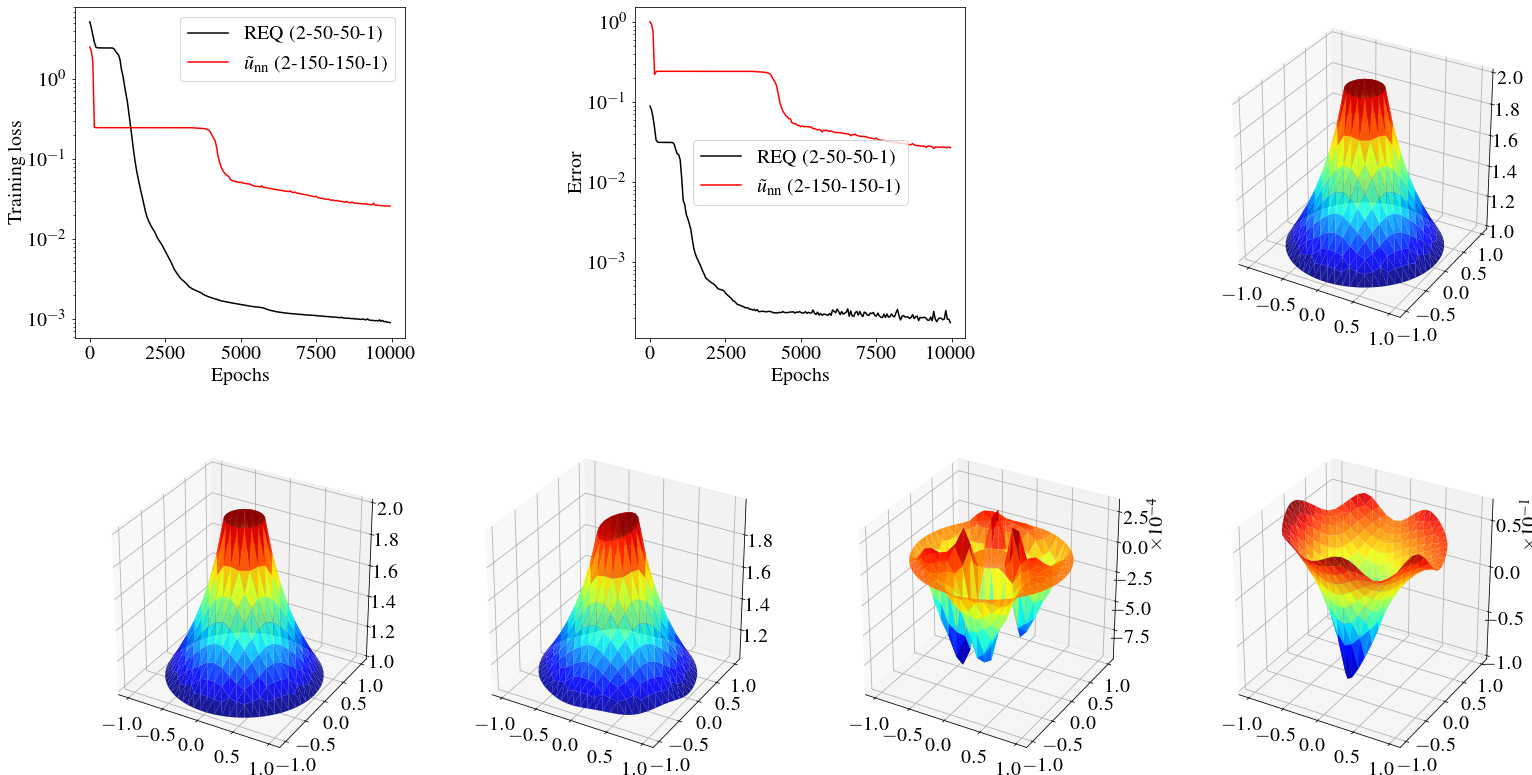

In [ ]:
#@title Laplace problem on an annulus with Dirichlet BC

numBatches = 1
num_epochs = 10000

#Mesh
geo = dmsh.Difference(dmsh.Circle([0.0, 0.0], 1.0), dmsh.Circle([0.0, 0.0], 0.25))
X, cells = dmsh.generate(geo, 0.1)
X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
mesh = meshplex.MeshTri(X, cells)
#interior
inputx = mesh.cell_centroids[:,0]
inputy = mesh.cell_centroids[:,1]
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

# dmsh.helpers.show(X, cells, geo)
# geo.show()



#Outer circle
geo1 = dmsh.Circle([0.0, 0.0], 1.0)
X1, cells1 = dmsh.generate(geo1, 0.1)
X1, cells1 = optimesh.optimize_points_cells(X1, cells1, "CVT (full)", 1.0e-10, 100)
mesh1 = meshplex.MeshTri(X1, cells1)

#Interior circle
geo2 = dmsh.Circle([0.0, 0.0], 0.25)
X2, cells2 = dmsh.generate(geo2, 0.05)
X2, cells2 = optimesh.optimize_points_cells(X2, cells2, "CVT (full)", 1.0e-10, 100)
mesh2 = meshplex.MeshTri(X2, cells2)


#Boundary points
Xb1 = X1[mesh1.is_boundary_point]
Xb2 = X2[mesh2.is_boundary_point]
xb1, yb1 = Xb1[:,0], Xb1[:,1]
xb2, yb2 = Xb2[:,0], Xb2[:,1]


# #For plotting
x = mesh.points[:,0]
y = mesh.points[:,1]

#NN
layer_sizes = [2, 50, 50, 1]

def exact(x,y):
  return np.log(np.sqrt(x**2+y**2))/np.log(0.25) + 1.

e_vect = vmap(exact, (0, 0))

###################################
#R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def phi_c(x, y):
    phi1 = np.sqrt(x**2+y**2)-1.
    phi2 = np.sqrt(x**2+y**2)-.25
    phi1 = -1.*phi1
    phi = (phi1*phi2)/(phi1+phi2)
    return phi

def g_c(x, y):
    phi1 = np.sqrt(x**2+y**2)-1.
    phi2 = np.sqrt(x**2+y**2)-.25
    phi1 = -1.*phi1
    g = (2*phi1+phi2)/(phi1+phi2)
    
    return g    

phi_c_vect = vmap(phi_c, (0, 0))
g_c_vect = vmap(g_c, (0, 0))

def uR(params, x, y):
    phi1 = np.sqrt(x**2+y**2)-1.
    phi2 = np.sqrt(x**2+y**2)-.25
    phi1 = -1.*phi1
    phi = R_eq(phi1,phi2,1)
    g = (2*phi1+phi2)/(phi1+phi2)

    return phi*NN(params,x,y)+g

def lossR(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y)
    return np.mean(eq**2)

grad1 = grad(grad(uR,1),1)
grad2 = grad(grad(uR,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorR1 = e
lossR1 = train_loss
approxSolnR1 = numpy.array(u_vect(params, x, y))
approxSolnR1[numpy.isnan(approxSolnR1)] = 0.

exactSoln1 = numpy.array(e_vect(x,y))
##########################################################


###################################
#No Dirichlet

layer_sizes = [2, 150, 150, 1]

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uNBC(params, x, y):
    return NN(params,x,y)

def lossNBC(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y)
    bc1 = u_vect(params,xb1,yb1)-1.
    bc2 = u_vect(params,xb2,yb2)-2.
    return np.mean(eq**2) + (np.mean(bc1**2) + np.mean(bc2**2))/2.

grad1 = grad(grad(uNBC,1),1)
grad2 = grad(grad(uNBC,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uNBC, (None, 0, 0))


def run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateNBC(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateNBC(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossNBC)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er
    
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorNBC1 = e
lossNBC1 = train_loss
approxSolnNBC1 = numpy.array(u_vect(params, x, y))
approxSolnNBC1[numpy.isnan(approxSolnNBC1)] = 0.

##########################################################

e_dx = 50

plt.rcParams.update({'font.size': 20})
######
#Plots

fig = plt.figure(figsize=(26, 14))
gs = gridspec.GridSpec(2, 8)
gs.update(wspace=.3)
gs.update(hspace=.3)
ax1 = plt.subplot(gs[0, 0:2])
ax2 = plt.subplot(gs[0, 3:5])
ax3 = plt.subplot(gs[0, 6:8], projection = '3d')
ax4 = plt.subplot(gs[1, 0:2], projection = '3d')
ax5 = plt.subplot(gs[1, 2:4], projection = '3d')
ax6 = plt.subplot(gs[1, 4:6], projection = '3d')
ax7 = plt.subplot(gs[1, 6:8], projection = '3d')

ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="black", label='REQ (2-50-50-1)')
ax1.plot(range(num_epochs)[::e_dx],lossNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$ (2-150-150-1)')
# ax1.set_title('$k=1$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')


ax2.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="black", label='REQ (2-50-50-1)')
ax2.plot(range(num_epochs)[::e_dx],errorNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$ (2-150-150-1)')
# ax1.set_title('$k=1$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')

ax3.plot_trisurf(x, y, exactSoln1, cmap=plt.cm.jet, alpha=0.9)
# ax3.set_title('Exact solution')
# ax3.set_xlabel('$x$')
# ax3.set_ylabel('$y$')


ax4.plot_trisurf(x, y, approxSolnR1, cmap=plt.cm.jet, alpha=0.9)
# ax4.set_title('$REQ (2-50-50-1)')
# ax4.set_xlabel('$x$')
# ax4.set_ylabel('$y$')

ax5.plot_trisurf(x, y, approxSolnNBC1, cmap=plt.cm.jet, alpha=0.9)
# ax5.set_title('$\\tilde{u}_\mathrm{nn}$ (2-150-150-1)')
# ax5.set_xlabel('$x$')
# ax5.set_ylabel('$y$')

ax6.plot_trisurf(x, y, approxSolnR1-exactSoln1, cmap=plt.cm.jet, alpha=0.9)
# ax6.set_title('$R-$equivalence error')
# ax6.set_xlabel('$x$')
# ax6.set_ylabel('$y$')

ax7.plot_trisurf(x, y, approxSolnNBC1-exactSoln1, cmap=plt.cm.jet, alpha=0.9)
# ax7.set_title('Std. PINN error')
# ax7.set_xlabel('$x$')
# ax7.set_ylabel('$y$')

ax3.locator_params(nbins=6)
ax4.locator_params(nbins=6)
ax5.locator_params(nbins=6)
ax6.locator_params(nbins=6)
ax7.locator_params(nbins=6)

ax6.ticklabel_format(style='sci', axis='z', scilimits=(0,0))
ax7.ticklabel_format(style='sci', axis='z', scilimits=(0,0))

# plt.tight_layout()
fig.savefig('Heat-Circular.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0.3)


plt.show()



plt.rcParams.update({'font.size': 20})
######
#Plots

n=2
fig = plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(1, n)
gs.update(wspace=0.2)
# gs.update(hspace=.25)
ax1 = plt.subplot(gs[0, 0], projection = '3d')
ax2 = plt.subplot(gs[0, 1], projection = '3d')
# ax3 = plt.subplot(gs[0, 2], projection = '3d')

ax1.plot_trisurf(x, y, -phi_c_vect(x,y), lw=0., edgecolor="black", cmap=plt.cm.jet,
                alpha=0.9)
ax2.plot_trisurf(x, y, g_c_vect(x,y), lw=0., edgecolor="black", cmap=plt.cm.jet,
                alpha=0.9)

ax1.locator_params(nbins=8)
ax2.locator_params(nbins=8)
# ax3.plot_trisurf(x, y, approxSolnNBC1, cmap=plt.cm.Spectral)

# a = numpy.array(exactSoln1 - approxSolnR1)
# b = numpy.array(exactSoln1 - approxSolnM1)
# c = numpy.array(exactSoln1 - approxSolnNBC1)

# X,Y,A = gridValues(x,y,a)
# X,Y,B = gridValues(x,y,b)
# X,Y,C = gridValues(x,y,c)

# ax1.plot_surface(X, Y, A, cmap=plt.cm.Spectral)
# ax2.plot_surface(X, Y, B, cmap=plt.cm.Spectral)
# ax3.plot_surface(X, Y, C, cmap=plt.cm.Spectral)
# # ax3.plot_surface(X, Y, C, cmap=plt.cm.Spectral)
# # ax4.plot_surface(X, Y, D, cmap=plt.cm.Spectral)

# ax1.set_title('-$\phi(\mathbf{x})$')
# ax2.set_title('$g(\mathbf{x})$')
# ax3.set_title('$\\tilde{u}_\mathrm{nn}(\mathbf{x},\\theta)$')
# # ax3.set_title('$\\nabla^2 \phi_R$')
# # ax4.set_title('$\\nabla^2 \phi_M$')

# ax1.set_xlabel('$x$')
# ax1.set_ylabel('$y$')
# ax2.set_xlabel('$x$')
# ax2.set_ylabel('$y$')
# ax3.set_xlabel('$x$')
# ax3.set_ylabel('$y$')
# # ax4.set_xlabel('$x$')
# # ax4.set_ylabel('$y$')

# # ax1.dist = 11

ax1.locator_params(nbins=6)
ax2.locator_params(nbins=6)


fig.savefig('Heat-Circular-phi-g.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0.6)

plt.show()

epoch:   0 loss: 550.269226
epoch: 1000 loss: 506.893707
epoch: 2000 loss: 315.079926
epoch: 3000 loss: 264.723938
epoch: 4000 loss: 198.431183
epoch: 5000 loss: 118.881691
epoch: 6000 loss: 54.433449
epoch: 7000 loss: 24.051159
epoch: 8000 loss: 10.629422
epoch: 9000 loss: 5.561306
epoch: 10000 loss: 5.029752
epoch: 11000 loss: 4.619249
epoch: 12000 loss: 4.108109
epoch: 13000 loss: 3.379702
epoch: 14000 loss: 2.377209
epoch: 15000 loss: 1.169226
epoch: 16000 loss: 1.061536
epoch: 17000 loss: 1.044861
epoch: 18000 loss: 1.028918
epoch: 19000 loss: 1.015580
epoch: 20000 loss: 1.002748
epoch: 21000 loss: 0.984928
epoch: 22000 loss: 0.957139
epoch: 23000 loss: 0.925108
epoch: 24000 loss: 0.892436
epoch: 25000 loss: 0.865373
epoch: 26000 loss: 0.838180
epoch: 27000 loss: 0.806793
epoch: 28000 loss: 0.769234
epoch: 29000 loss: 0.724203


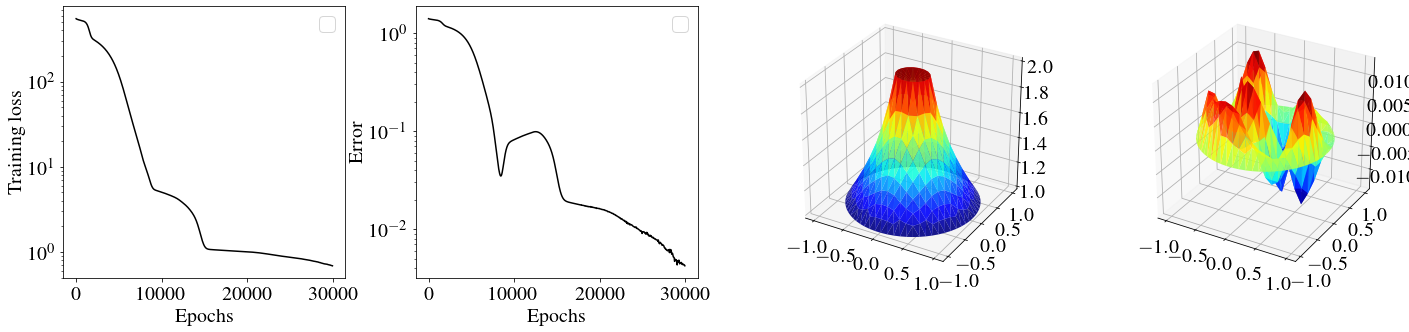

In [ ]:
#@title Laplace problem on an annulus with mixed BC

numBatches = 1
num_epochs = 30000

c = 1.
h = 2. + 4./np.log(4.)
g = 1.

#Mesh
geo = dmsh.Difference(dmsh.Circle([0.0, 0.0], 1.0), dmsh.Circle([0.0, 0.0], 0.25))
X, cells = dmsh.generate(geo, 0.1)
X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
mesh = meshplex.MeshTri(X, cells)
#interior
inputx = mesh.cell_centroids[:,0]
inputy = mesh.cell_centroids[:,1]
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)


#Outer circle
geo1 = dmsh.Circle([0.0, 0.0], 1.0)
X1, cells1 = dmsh.generate(geo1, 0.1)
X1, cells1 = optimesh.optimize_points_cells(X1, cells1, "CVT (full)", 1.0e-10, 100)
mesh1 = meshplex.MeshTri(X1, cells1)

#Interior circle
geo2 = dmsh.Circle([0.0, 0.0], 0.25)
X2, cells2 = dmsh.generate(geo2, 0.05)
X2, cells2 = optimesh.optimize_points_cells(X2, cells2, "CVT (full)", 1.0e-10, 100)
mesh2 = meshplex.MeshTri(X2, cells2)


#Boundary points
Xb1 = X1[mesh1.is_boundary_point]
Xb2 = X2[mesh2.is_boundary_point]
xb1, yb1 = Xb1[:,0], Xb1[:,1]
xb2, yb2 = Xb2[:,0], Xb2[:,1]


# #For plotting
x = mesh.points[:,0]
y = mesh.points[:,1]

#NN
layer_sizes = [2, 50, 50, 1]

def exact(x,y):
  return np.log(np.sqrt(x**2+y**2))/np.log(0.25) + 1.

e_vect = vmap(exact, (0, 0))

###################################
#R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def phi1(x,y):
  return -(np.sqrt(x**2+y**2)-1.)

def phi2(x,y):
  return (np.sqrt(x**2+y**2)-.25)

NNx = grad(NN,1)
NNy = grad(NN,2)
p2x = grad(phi2,0)
p2y = grad(phi2,1)
p1x = grad(phi1,0)
p1y = grad(phi1,1)

# def uR(params, x, y):
#     p1 = phi1(x,y)
#     p2 = phi2(x,y)
#     u = NN(params,x,y)
#     Dphi2 = p2x(x,y)*NNx(params,x,y) + p2y(x,y)*NNy(params,x,y)
#     u1 = p1*u+1.
#     # u1 = 1.
#     u2 = (u+p2*Dphi2) + 1.*p2/(0.25*np.log(0.25)) + p2**2*u
#     w1 = p1/(p1+p2**2)
#     w2 = p2**2/(p1+p2**2)

#     return w1*u2+w2*u1+p1*p2**2*u


def uR(params, x, y):
    p1 = phi1(x,y)
    p2 = phi2(x,y)
    u = NN(params,x,y)
    Dphi2 = p2x(x,y)*NNx(params,x,y) + p2y(x,y)*NNy(params,x,y)
    u1 = p1*u+1.
    # u1 = 1.
    u2 = (u+p2*Dphi2+p2*u) - h*p2 #+ p2**2*u
    w1 = p1/(p1+p2**2)
    w2 = p2**2/(p1+p2**2)

    return w1*u2+w2*u1+p1*p2**2*u


# def uR(params, x, y):

#     p1 = phi1(x,y)
#     p1X, p1Y = p1x(x,y), p1y(x,y)
#     p2X, p2Y = p2x(x,y), p2y(x,y)
#     p2 = phi2(x,y)
#     u = NN(params,x,y)
#     uX, uY = NNx(params,x,y), NNy(params,x,y)
#     Dphi2 = p2X*(p1*uX + p1X*u) + p2Y*(p1*uY + p1Y*u)

#     return p1*u + (p1*p2/(p1+p2))*(p2*u + c*p1*u + Dphi2 + c*g - h) + g


def lossR(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y)
    return np.mean(eq**2)

grad1 = grad(grad(uR,1),1)
grad2 = grad(grad(uR,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorR1 = e
lossR1 = train_loss
approxSolnR1 = numpy.array(u_vect(params, x, y))
approxSolnR1[numpy.isnan(approxSolnR1)] = 0.

exactSoln1 = numpy.array(e_vect(x,y))
##########################################################


e_dx = 50

plt.rcParams.update({'font.size': 20})
######
#Plots

fig = plt.figure(figsize=(24, 5))
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=.25)
# gs.update(hspace=.15)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2], projection = '3d')
ax4 = plt.subplot(gs[0, 3], projection = '3d')
# ax5 = plt.subplot(gs[1, 2:4], projection = '3d')
# ax6 = plt.subplot(gs[1, 4:6], projection = '3d')
# ax7 = plt.subplot(gs[1, 6:8], projection = '3d')

ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="black")
# ax1.plot(range(num_epochs)[::e_dx],lossNBC1[::e_dx], color="orange", label='Std. PINN (2-150-150-1)')
# ax1.set_title('$k=1$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')


ax2.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="black")
# ax2.plot(range(num_epochs)[::e_dx],errorNBC1[::e_dx], color="orange", label='Std. PINN (2-150-150-1)')
# ax1.set_title('$k=1$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')

ax3.plot_trisurf(x, y, approxSolnR1, cmap=plt.cm.jet, alpha=0.9)
# ax3.set_title('Approximate solution')
# ax3.set_xlabel('$x$')
# ax3.set_ylabel('$y$')


ax4.plot_trisurf(x, y, approxSolnR1-exactSoln1, cmap=plt.cm.jet, alpha=0.9)
# ax4.set_title('Error')
# ax4.set_xlabel('$x$')
# ax4.set_ylabel('$y$')

ax3.locator_params(nbins=6)
ax4.locator_params(nbins=6)
# ax5.locator_params(nbins=8)
# ax6.locator_params(nbins=8)
# ax7.locator_params(nbins=8)

# plt.tight_layout()
fig.savefig('Heat-Circular-Mixed.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0.2)


plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


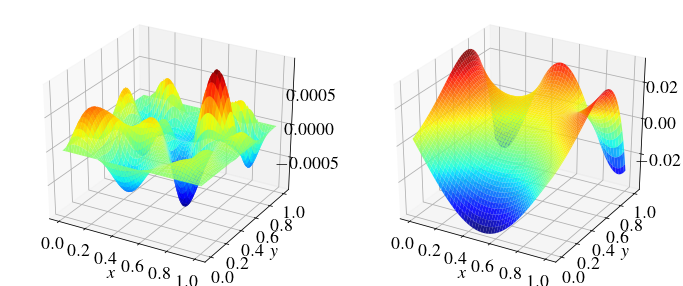

In [ ]:
#@title Steady state heat conduction
#Dirichlet = sin pi x on the top

#Domain boundary
ax,bx = 0.,1.
ay,by = 0.,1.

segments = np.array([[0.,0.,1.,0.],[1.,0.,1.,1.],[1.,1.,0.,1.],[0.,1.,0.,0.]])

numBatches = 1
num_epochs = 10000

# numInt = 5000

dx = 0.01
#interior
inputx = numpy.linspace(ax+dx, bx-dx, num=100)
inputy = numpy.linspace(ay+dx, by-dx, num=100)
inputx, inputy = np.meshgrid(inputx, inputy)
inputx, inputy = inputx.flatten(), inputy.flatten()
# inputx = numpy.random.uniform(ax, bx,numInt)
# inputy = numpy.random.uniform(ay, by,numInt)
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

#For plotting
x = numpy.linspace(ax, bx, num=100)
y = numpy.linspace(ay, by-.00001, num=100)
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()


#NN
layer_sizes = [2, 50, 50, 1]

def exact(x,y):
  return (1./(np.exp(np.pi)-np.exp(-np.pi)))*np.sin(np.pi*x)*(np.exp(np.pi*y)-np.exp(-np.pi*y))

def top(x,y):
  return np.sin(np.pi*x)

e_vect = vmap(exact, (0, 0))
top_vect = vmap(top, (0, 0))

###################################
#R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uR(params, x, y):
    N=2
    # ver=tanh(N*dist(x,y,0,0))*tanh(N*dist(x,y,0,1))*tanh(N*dist(x,y,1,0))*tanh(N*dist(x,y,1,1))
    # ver=tanh(dist(x,y,0,0)**N)*tanh(N*dist(x,y,0,1)**N)*tanh(N*dist(x,y,1,0)**N)*tanh(N*dist(x,y,1,1)**N)
    ver=1
    # ver=R_eq(R_eq(R_eq(tanh(dist(x,y,0,0)**N),tanh(dist(x,y,0,1)**N),1),tanh(dist(x,y,1,1)**N),1),tanh(dist(x,y,1,0)**N),1)
    return ver*phi(x,y,segments)*NN(params,x,y)+g(x,y,segments)

def lossR(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y)
    return np.mean(eq**2)

grad1 = grad(grad(uR,1),1)
grad2 = grad(grad(uR,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorR1 = e
lossR1 = train_loss
approxSolnR1 = numpy.array(u_vect(params, x, y))
approxSolnR1[numpy.isnan(approxSolnR1)] = 0.

exactSoln1 = numpy.array(e_vect(x,y))
##########################################################


###################################
#Dirichlet Mean value

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uM(params, x, y):
    return meanValue(x,y,segments)*NN(params,x,y)+g(x,y,segments)

def lossM(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y)
    return np.mean(eq**2)

grad1 = grad(grad(uM,1),1)
grad2 = grad(grad(uM,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uM, (None, 0, 0))

def run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateM(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateM(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossM)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorM1 = e
lossM1 = train_loss
approxSolnM1 = numpy.array(u_vect(params, x, y))
approxSolnM1[numpy.isnan(approxSolnM1)] = 0.

##########################################################



###################################
#No Dirichlet

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

numB = 100
input = np.linspace(0., 1., num=numB)

def uNBC(params, x, y):
    return NN(params,x,y)

def lossNBC(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y)
    bdb = u_vect(params,input,0.*np.ones(shape=(numB,)))
    bdt = u_vect(params,input,1.*np.ones(shape=(numB,))) - top_vect(input,1.*np.ones(shape=(numB,)))
    bdl = u_vect(params,0.*np.ones(shape=(numB,)),input)
    bdr = u_vect(params,1.*np.ones(shape=(numB,)),input)
    return np.mean(eq**2) +(np.mean(bdb**2) + np.mean(bdt**2) + np.mean(bdr**2) + np.mean(bdl**2))/4

grad1 = grad(grad(uNBC,1),1)
grad2 = grad(grad(uNBC,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uNBC, (None, 0, 0))


def run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateNBC(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateNBC(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossNBC)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er
    
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorNBC1 = e
lossNBC1 = train_loss
approxSolnNBC1 = numpy.array(u_vect(params, x, y))
approxSolnNBC1[numpy.isnan(approxSolnNBC1)] = 0.

##########################################################

e_dx = 50

# plt.rcParams.update({'font.size': 20})
# ######
# #Plots



# fig = plt.figure(figsize=(21, 11))
# gs = gridspec.GridSpec(2, 4)
# gs.update(wspace=.3)
# gs.update(hspace=.45)
# ax1 = plt.subplot(gs[0, 1])
# ax2 = plt.subplot(gs[0, 2])
# ax3 = plt.subplot(gs[1, 0])
# ax4 = plt.subplot(gs[1, 1])
# ax5 = plt.subplot(gs[1, 2])
# ax6 = plt.subplot(gs[1, 3])

# ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="black", label='REQ')
# # ax1.plot(range(num_epochs)[::e_dx],lossM1[::e_dx], color="blue", label='MVP')
# ax1.plot(range(num_epochs)[::e_dx],lossNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# # ax1.set_title('$k=1$')
# ax1.set_yscale('log')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Training loss')
# ax1.legend(loc='best')


# ax2.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="black", label='REQ')
# # ax2.plot(range(num_epochs)[::e_dx],errorM1[::e_dx], color="blue", label='MVP')
# ax2.plot(range(num_epochs)[::e_dx],errorNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# # ax1.set_title('$k=1$')
# ax2.set_yscale('log')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Error')
# ax2.legend(loc='best')



# plt.show()










# fig = plt.figure(figsize=(21, 11))
# gs = gridspec.GridSpec(2, 4)
# gs.update(wspace=.3)
# gs.update(hspace=.45)
# ax1 = plt.subplot(gs[0, 1])
# ax2 = plt.subplot(gs[0, 2])
# ax3 = plt.subplot(gs[1, 0])
# ax4 = plt.subplot(gs[1, 1])
# ax5 = plt.subplot(gs[1, 2])
# ax6 = plt.subplot(gs[1, 3])

# ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="black", label='REQ')
# ax1.plot(range(num_epochs)[::e_dx],lossM1[::e_dx], color="blue", label='MVP')
# ax1.plot(range(num_epochs)[::e_dx],lossNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# # ax1.set_title('$k=1$')
# ax1.set_yscale('log')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Training loss')
# ax1.legend(loc='best')


# ax2.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="black", label='REQ')
# ax2.plot(range(num_epochs)[::e_dx],errorM1[::e_dx], color="blue", label='MVP')
# ax2.plot(range(num_epochs)[::e_dx],errorNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# # ax1.set_title('$k=1$')
# ax2.set_yscale('log')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Error')
# ax2.legend(loc='best')


# X,Y,Z = gridValues(x,y,exactSoln1)

# ax3.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
# # ax3.set_title('Exact solution')
# ax3.set_xlabel('$x$')
# ax3.set_ylabel('$y$')


# X,Y,Z = gridValues(x,y,approxSolnR1)

# ax4.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
# # ax4.set_title('$R-$equivalence')
# ax4.set_xlabel('$x$')
# ax4.set_ylabel('$y$')

# X,Y,Z = gridValues(x,y,approxSolnM1)

# ax5.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
# # ax5.set_title('MVP')
# ax5.set_xlabel('$x$')
# ax5.set_ylabel('$y$')


# X,Y,Z = gridValues(x,y,approxSolnNBC1)

# im = ax6.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
# # ax6.set_title('Std. PINN')
# ax6.set_xlabel('$x$')
# ax6.set_ylabel('$y$')


# axins = inset_axes(ax6,
#                    width="5%",  # width = 5% of parent_bbox width
#                    height="100%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(1.05, 0., 1, 1),
#                    bbox_transform=ax6.transAxes,
#                    borderpad=0,
#                    )
# fig.colorbar(im, cax=axins)

# # plt.tight_layout()
# fig.savefig('Heat-NonZeroDirichlet.pdf', format='pdf', bbox_inches = 'tight',
#     pad_inches = 0)


# plt.show()



plt.rcParams.update({'font.size': 18})
######
#Plots

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)
# gs.update(hspace=.25)
# ax1 = plt.subplot(gs[0, 0])
# ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 0], projection = '3d')
ax4 = plt.subplot(gs[0, 1], projection = '3d')

# ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="black", label='REQ')
# ax1.plot(range(num_epochs)[::e_dx],lossNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# # ax1.set_title('$k=1$')
# ax1.set_yscale('log')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Loss')
# ax1.legend(loc='best')


# ax2.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="black", label='REQ')
# # ax2.plot(range(num_epochs)[::e_dx],errorM1[::e_dx], color="blue", label='MVP')
# ax2.plot(range(num_epochs)[::e_dx],errorNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# # ax1.set_title('$k=1$')
# ax2.set_yscale('log')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Error')
# ax2.legend(loc='best')


a = numpy.array(exactSoln1 - approxSolnR1)
# b = numpy.array(exactSoln1 - approxSolnM1)
c = numpy.array(exactSoln1 - approxSolnNBC1)

X,Y,A = gridValues(x,y,a)
# X,Y,B = gridValues(x,y,b)
X,Y,C = gridValues(x,y,c)

# ax1.plot_surface(X, Y, A, cmap=plt.cm.jet, alpha=0.9)
# ax2.plot_surface(X, Y, B, cmap=plt.cm.jet, alpha=0.9)
ax3.plot_surface(X, Y, A, cmap=plt.cm.jet, alpha=0.9)
ax4.plot_surface(X, Y, C, cmap=plt.cm.jet, alpha=0.9)
# ax3.plot_surface(X, Y, C, cmap=plt.cm.Spectral)
# ax4.plot_surface(X, Y, D, cmap=plt.cm.Spectral)

# ax1.set_title('$R-$equivalence')
# ax2.set_title('MVP')
# ax3.set_title('Std. PINN')
# ax3.set_title('$\\nabla^2 \phi_R$')
# ax4.set_title('$\\nabla^2 \phi_M$')

# ax1.set_xlabel('$x$')
# ax1.set_ylabel('$y$')
# ax2.set_xlabel('$x$')
# ax2.set_ylabel('$y$')
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax4.set_xlabel('$x$')
ax4.set_ylabel('$y$')
# ax4.set_xlabel('$x$')
# ax4.set_ylabel('$y$')

# ax1.locator_params(nbins=6)
# ax2.locator_params(nbins=6)
ax3.locator_params(nbins=6)
ax4.locator_params(nbins=6)

# ax1.dist = 11

plt.tight_layout()
fig.savefig('Heat-NonZeroDirichlet-errors.pdf', format='pdf')

plt.show()

epoch:   0 loss: 1.756638
epoch: 1000 loss: 1.587019
epoch: 2000 loss: 1.586780
epoch: 3000 loss: 1.586660
epoch: 4000 loss: 1.586590
epoch: 5000 loss: 1.586529
epoch: 6000 loss: 1.586470
epoch: 7000 loss: 1.586418
epoch: 8000 loss: 1.586367
epoch: 9000 loss: 1.586332


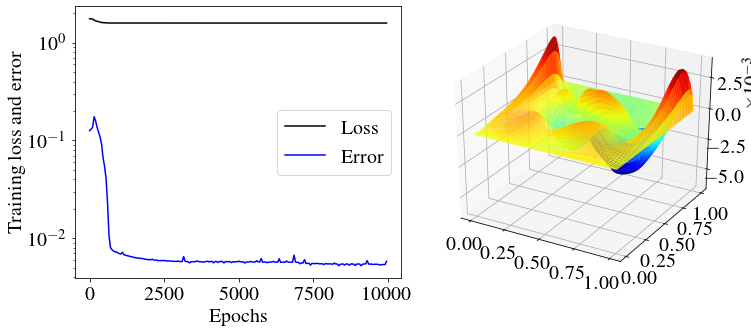

In [ ]:
#@title Steady state heat conduction with Ritz

#ia. Steady state heat conduction
#Dirichlet = sin pi x on the top

#Domain boundary
ax,bx = 0.,1.
ay,by = 0.,1.

segments = np.array([[0.,0.,1.,0.],[1.,0.,1.,1.],[1.,1.,0.,1.],[0.,1.,0.,0.]])

numBatches = 1
num_epochs = 10000

# numInt = 5000

dx = 0.00001
#interior
inputx = numpy.linspace(ax+dx, bx-dx, num=300)
inputy = numpy.linspace(ay+dx, by-dx, num=300)
inputx, inputy = np.meshgrid(inputx, inputy)
inputx, inputy = inputx.flatten(), inputy.flatten()
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

#For plotting
x = numpy.linspace(ax, bx, num=100)
y = numpy.linspace(ay, by-.00001, num=100)
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()


#NN
layer_sizes = [2, 30, 30, 1]

def exact(x,y):
  return (1./(np.exp(np.pi)-np.exp(-np.pi)))*np.sin(np.pi*x)*(np.exp(np.pi*y)-np.exp(-np.pi*y))

e_vect = vmap(exact, (0, 0))

###################################
#R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uR(params, x, y):
    return phi(x,y,segments)*NN(params,x,y)+g(x,y,segments)

def lossR(params, x, y):
    eq = dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2
    return np.mean(eq)

grad1 = grad(uR,1)
grad2 = grad(uR,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorR1 = e
lossR1 = train_loss
approxSolnR1 = numpy.array(u_vect(params, x, y))
approxSolnR1[numpy.isnan(approxSolnR1)] = 0.

exactSoln1 = numpy.array(e_vect(x,y))
##########################################################

e_dx = 50

plt.rcParams.update({'font.size': 20})
######
#Plots

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=.05)
# gs.update(hspace=.35)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1], projection='3d')
# ax3 = plt.subplot(gs[1, 0])
# ax4 = plt.subplot(gs[1, 1])
# ax5 = plt.subplot(gs[1, 2])
# ax6 = plt.subplot(gs[1, 3])

ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="black", label='Loss')
ax1.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="blue", label='Error')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss and error')
ax1.legend(loc='best')

a = numpy.array(exactSoln1 - approxSolnR1)
X,Y,A = gridValues(x,y,a)
ax2.plot_surface(X, Y, A, cmap=plt.cm.jet, alpha=0.9)

# ax2.set_xlabel('$x$')
# ax2.set_ylabel('$y$')
# ax2.set_title('$R-$equivalence')

ax2.ticklabel_format(style='sci', axis='z', scilimits=(0,0))

# plt.tight_layout()
# fig.savefig('Heat-NonZeroDirichlet-Ritz.pdf', format='pdf')
fig.savefig('Heat-NonZeroDirichlet-Ritz.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = .2)

plt.show()




epoch:   0 loss: 0.259450
epoch: 1000 loss: 0.056861
epoch: 2000 loss: 0.026406
epoch: 3000 loss: 0.021849
epoch: 4000 loss: 0.020136
epoch: 5000 loss: 0.019179
epoch: 6000 loss: 0.018460
epoch: 7000 loss: 0.017922
epoch: 8000 loss: 0.017523
epoch: 9000 loss: 0.017196
epoch:   0 loss: 0.259494
epoch: 1000 loss: 0.000708
epoch: 2000 loss: 0.000320
epoch: 3000 loss: 0.000204
epoch: 4000 loss: 0.000148
epoch: 5000 loss: 0.000112
epoch: 6000 loss: 0.000096
epoch: 7000 loss: 0.000085
epoch: 8000 loss: 0.000076
epoch: 9000 loss: 0.000068
epoch:   0 loss: 0.259493
epoch: 1000 loss: 0.000250
epoch: 2000 loss: 0.000080
epoch: 3000 loss: 0.000046
epoch: 4000 loss: 0.000033
epoch: 5000 loss: 0.000027
epoch: 6000 loss: 0.000024
epoch: 7000 loss: 0.000021
epoch: 8000 loss: 0.000019
epoch: 9000 loss: 0.000018
epoch:   0 loss: 0.250879
epoch: 1000 loss: 0.250628
epoch: 2000 loss: 0.012549
epoch: 3000 loss: 0.007655
epoch: 4000 loss: 0.004443
epoch: 5000 loss: 0.002752
epoch: 6000 loss: 0.001806
epoch

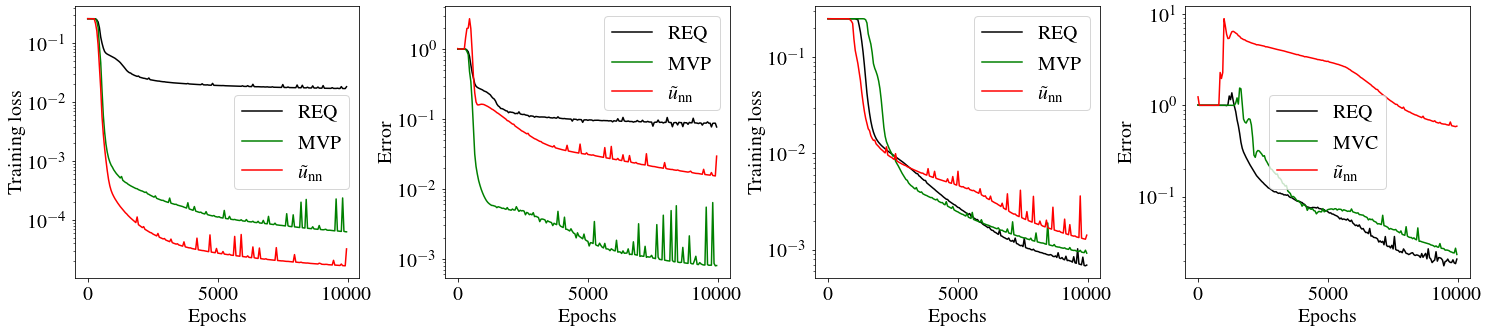

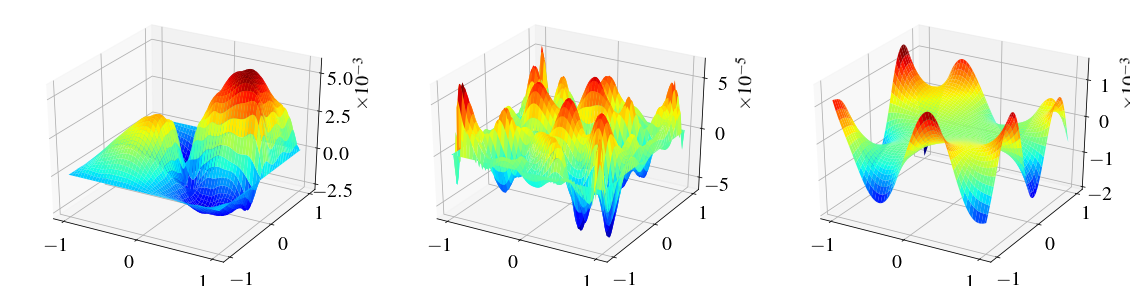

In [ ]:
#@title Convergence study in a steady state heat conduction problem
k=1.

#Domain boundary
ax,bx = -1.,1.
ay,by = -1.,1.

segments = np.array([[ax,ay,bx,ay],[bx,ay,bx,by],[bx,by,ax,by],[ax,by,ax,ay]])

numBatches = 1
num_epochs = 10000

numInt = 5000

#interior
inputx = numpy.random.uniform(ax+.01, bx-.01,numInt)
inputy = numpy.random.uniform(ay+.01, by-.01,numInt)
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

#For plotting
# x = numpy.random.uniform(ax, bx,5000)
# y = numpy.random.uniform(ay, by,5000)
x = numpy.linspace(ax, bx, num=100)
y = numpy.linspace(ay, by, num=100)
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()


#NN
layer_sizes = [2, 50, 50, 1]

def f(x,y):
  return np.sin(k*np.pi*x)*np.sin(k*np.pi*y)

f_vect = vmap(f, (0, 0))

def exact(x,y):
  return (1/2.)*np.sin(k*np.pi*x)*np.sin(k*np.pi*y)/(k**2*np.pi**2)

e_vect = vmap(exact, (0, 0))



###################################
#Dirichlet R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uR(params, x, y):
    N=2
    ver=R_eq(R_eq(R_eq(tanh(dist(x,y,0,0)**N),tanh(dist(x,y,0,1)**N),1),tanh(dist(x,y,1,1)**N),1),tanh(dist(x,y,1,0)**N),1)
    return ver*phi(x,y,segments)*NN(params,x,y)

def lossR(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y) + f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(grad(uR,1),1)
grad2 = grad(grad(uR,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorR1 = e
lossR1 = train_loss
approxSolnR1 = numpy.array(u_vect(params, x, y))
approxSolnR1[numpy.isnan(approxSolnR1)] = 0.

exactSoln1 = numpy.array(e_vect(x,y))

errorxyR1 = numpy.abs(exactSoln1 - approxSolnR1)/numpy.sqrt(numpy.mean(exactSoln1**2))
##########################################################


###################################
#Dirichlet Mean value

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uM(params, x, y):
    return meanValue(x,y,segments)*NN(params,x,y)

def lossM(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y) + f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(grad(uM,1),1)
grad2 = grad(grad(uM,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uM, (None, 0, 0))

def run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateM(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateM(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossM)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorM1 = e
lossM1 = train_loss
approxSolnM1 = numpy.array(u_vect(params, x, y))
approxSolnM1[numpy.isnan(approxSolnM1)] = 0.
errorxyM1 = numpy.abs(exactSoln1 - approxSolnM1)/numpy.sqrt(numpy.mean(exactSoln1**2))

##########################################################



###################################
#No Dirichlet

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

numB = 100
input = np.linspace(-1., 1., num=numB)

def uNBC(params, x, y):
    return NN(params,x,y)

def lossNBC(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y) + f_vect(x,y)
    bdb = u_vect(params,input,-1.*np.ones(shape=(numB,)))
    bdt = u_vect(params,input,1.*np.ones(shape=(numB,)))
    bdl = u_vect(params,-1.*np.ones(shape=(numB,)),input)
    bdr = u_vect(params,1.*np.ones(shape=(numB,)),input)
    return np.mean(eq**2) + (np.mean(bdb**2) + np.mean(bdt**2) + np.mean(bdr**2) + np.mean(bdl**2))/4

def lossNBC1(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y) + f_vect(x,y)
    bdb = u_vect(params,input,-1.*np.ones(shape=(numB,)))
    bdt = u_vect(params,input,1.*np.ones(shape=(numB,)))
    bdl = u_vect(params,-1.*np.ones(shape=(numB,)),input)
    bdr = u_vect(params,1.*np.ones(shape=(numB,)),input)
    return np.mean(eq**2), (np.mean(bdb**2) + np.mean(bdt**2) + np.mean(bdr**2) + np.mean(bdl**2))/4


grad1 = grad(grad(uNBC,1),1)
grad2 = grad(grad(uNBC,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uNBC, (None, 0, 0))


def run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateNBC(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateNBC(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossNBC)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er
    
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorNBC1 = e
lossNBC1 = train_loss
approxSolnNBC1 = numpy.array(u_vect(params, x, y))
approxSolnNBC1[numpy.isnan(approxSolnNBC1)] = 0.
errorxyNBC1 = numpy.abs(exactSoln1 - approxSolnNBC1)/numpy.sqrt(numpy.mean(exactSoln1**2))

##########################################################





k=2.

#Domain boundary
ax,bx = -1.,1.
ay,by = -1.,1.

segments = np.array([[ax,ay,bx,ay],[bx,ay,bx,by],[bx,by,ax,by],[ax,by,ax,ay]])

numBatches = 1
num_epochs = 10000

numInt = 5000

#interior
inputx = numpy.random.uniform(ax+.01, bx-.01,numInt)
inputy = numpy.random.uniform(ay+.01, by-.01,numInt)
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

#For plotting
# x = numpy.random.uniform(ax, bx,5000)
# y = numpy.random.uniform(ay, by,5000)
x = numpy.linspace(ax, bx, num=100)
y = numpy.linspace(ay, by, num=100)
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()


#NN
layer_sizes = [2, 50, 50, 1]

def f(x,y):
  return np.sin(k*np.pi*x)*np.sin(k*np.pi*y)

f_vect = vmap(f, (0, 0))

def exact(x,y):
  return (1/2.)*np.sin(k*np.pi*x)*np.sin(k*np.pi*y)/(k**2*np.pi**2)

e_vect = vmap(exact, (0, 0))



###################################
#Dirichlet R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uR(params, x, y):
    return phi(x,y,segments)*NN(params,x,y)

def lossR(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y) + f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(grad(uR,1),1)
grad2 = grad(grad(uR,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorR2 = e
lossR2 = train_loss
approxSolnR2 = numpy.array(u_vect(params, x, y))
approxSolnR2[numpy.isnan(approxSolnR2)] = 0.

exactSoln2 = numpy.array(e_vect(x,y))

errorxyR2 = numpy.abs(exactSoln2 - approxSolnR2)/numpy.sqrt(numpy.mean(exactSoln2**2))
##########################################################


###################################
#Dirichlet Mean value

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uM(params, x, y):
    return meanValue(x,y,segments)*NN(params,x,y)

def lossM(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y) + f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(grad(uM,1),1)
grad2 = grad(grad(uM,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uM, (None, 0, 0))

def run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateM(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateM(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossM)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorM2 = e
lossM2 = train_loss
approxSolnM2 = numpy.array(u_vect(params, x, y))
approxSolnM2[numpy.isnan(approxSolnM2)] = 0.
errorxyM2 = numpy.abs(exactSoln2 - approxSolnM2)/numpy.sqrt(numpy.mean(exactSoln2**2))

##########################################################



###################################
#No Dirichlet

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

numB = 100
input = np.linspace(-1., 1., num=numB)

def uNBC(params, x, y):
    return NN(params,x,y)

def lossNBC(params, x, y):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y) + f_vect(x,y)
    bdb = u_vect(params,input,-1.*np.ones(shape=(numB,)))
    bdt = u_vect(params,input,1.*np.ones(shape=(numB,)))
    bdl = u_vect(params,-1.*np.ones(shape=(numB,)),input)
    bdr = u_vect(params,1.*np.ones(shape=(numB,)),input)
    return np.mean(eq**2) +(np.mean(bdb**2) + np.mean(bdt**2) + np.mean(bdr**2) + np.mean(bdl**2))/4

grad1 = grad(grad(uNBC,1),1)
grad2 = grad(grad(uNBC,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uNBC, (None, 0, 0))


def run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateNBC(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateNBC(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossNBC)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er
    
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorNBC2 = e
lossNBC2 = train_loss
approxSolnNBC2 = numpy.array(u_vect(params, x, y))
approxSolnNBC2[numpy.isnan(approxSolnNBC2)] = 0.
errorxyNBC2 = numpy.abs(exactSoln2 - approxSolnNBC2)/numpy.sqrt(numpy.mean(exactSoln2**2))

##########################################################



plt.rcParams.update({'font.size': 20})
######
#Plots
fig = plt.figure(figsize=(25, 5))
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=.3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

e_dx = 50

ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="black", label='REQ')
ax1.plot(range(num_epochs)[::e_dx],lossM1[::e_dx], color="green", label='MVP')
ax1.plot(range(num_epochs)[::e_dx],lossNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax1.set_title('$k=1$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')

ax2.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="black", label='REQ')
ax2.plot(range(num_epochs)[::e_dx],errorM1[::e_dx], color="green", label='MVP')
ax2.plot(range(num_epochs)[::e_dx],errorNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax2.set_title('$k=1$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')

ax3.plot(range(num_epochs)[::e_dx],lossR2[::e_dx], color="black", label='REQ')
ax3.plot(range(num_epochs)[::e_dx],lossM2[::e_dx], color="green", label='MVP')
ax3.plot(range(num_epochs)[::e_dx],lossNBC2[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax3.set_title('$k=2$')
ax3.set_yscale('log')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Training loss')
ax3.legend(loc='best')

ax4.plot(range(num_epochs)[::e_dx],errorR2[::e_dx], color="black", label='REQ')
ax4.plot(range(num_epochs)[::e_dx],errorM2[::e_dx], color="green", label='MVC')
ax4.plot(range(num_epochs)[::e_dx],errorNBC2[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax4.set_title('$k=2$')
ax4.set_yscale('log')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Error')
ax4.legend(loc='best')

fig.savefig('HeatEq.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()




plt.rcParams.update({'font.size': 20})
######
#Plots

fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.1)
# gs.update(hspace=.25)
ax1 = plt.subplot(gs[0, 0], projection = '3d')
ax2 = plt.subplot(gs[0, 1], projection = '3d')
ax3 = plt.subplot(gs[0, 2], projection = '3d')



a = numpy.array(exactSoln1 - approxSolnR1)
b = numpy.array(exactSoln1 - approxSolnM1)
c = numpy.array(exactSoln1 - approxSolnNBC1)

X,Y,A = gridValues(x,y,a)
X,Y,B = gridValues(x,y,b)
X,Y,C = gridValues(x,y,c)

ax1.plot_surface(X, Y, A, cmap=plt.cm.jet)
ax2.plot_surface(X, Y, B, cmap=plt.cm.jet)
ax3.plot_surface(X, Y, C, cmap=plt.cm.jet)
# ax3.plot_surface(X, Y, C, cmap=plt.cm.Spectral)
# ax4.plot_surface(X, Y, D, cmap=plt.cm.Spectral)

# ax1.set_title('REQ')
# ax2.set_title('MVP')
# ax3.set_title('$\\tilde{u}_\mathrm{nn}$')
# ax3.set_title('$\\nabla^2 \phi_R$')
# ax4.set_title('$\\nabla^2 \phi_M$')

# ax1.set_xlabel('$x$')
# ax1.set_ylabel('$y$')
# ax2.set_xlabel('$x$')
# ax2.set_ylabel('$y$')
# ax3.set_xlabel('$x$')
# ax3.set_ylabel('$y$')

ax1.locator_params(nbins=4)
ax2.locator_params(nbins=4)
ax3.locator_params(nbins=4)

# ax4.set_xlabel('$x$')
# ax4.set_ylabel('$y$')

ax1.ticklabel_format(style='sci', axis='z', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='z', scilimits=(0,0))
ax3.ticklabel_format(style='sci', axis='z', scilimits=(0,0))

fig.savefig('HeatEq-error2.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0.2)

plt.show()

epoch:   0 loss: 0.123929
epoch: 1000 loss: 0.000316
epoch: 2000 loss: 0.000071
epoch: 3000 loss: 0.000043
epoch: 4000 loss: 0.000033
epoch: 5000 loss: 0.000027
epoch: 6000 loss: 0.000022
epoch: 7000 loss: 0.000018
epoch: 8000 loss: 0.000016
epoch: 9000 loss: 0.000014
epoch:   0 loss: 0.024802
epoch: 1000 loss: 0.024784
epoch: 2000 loss: 0.012372
epoch: 3000 loss: 0.000018
epoch: 4000 loss: 0.000009
epoch: 5000 loss: 0.000006
epoch: 6000 loss: 0.000004
epoch: 7000 loss: 0.000003
epoch: 8000 loss: 0.000003
epoch: 9000 loss: 0.000002
epoch:   0 loss: 0.223056
epoch: 1000 loss: 0.000100
epoch: 2000 loss: 0.000045
epoch: 3000 loss: 0.000034
epoch: 4000 loss: 0.000028
epoch: 5000 loss: 0.000025
epoch: 6000 loss: 0.000021
epoch: 7000 loss: 0.000019
epoch: 8000 loss: 0.000019
epoch: 9000 loss: 0.000016


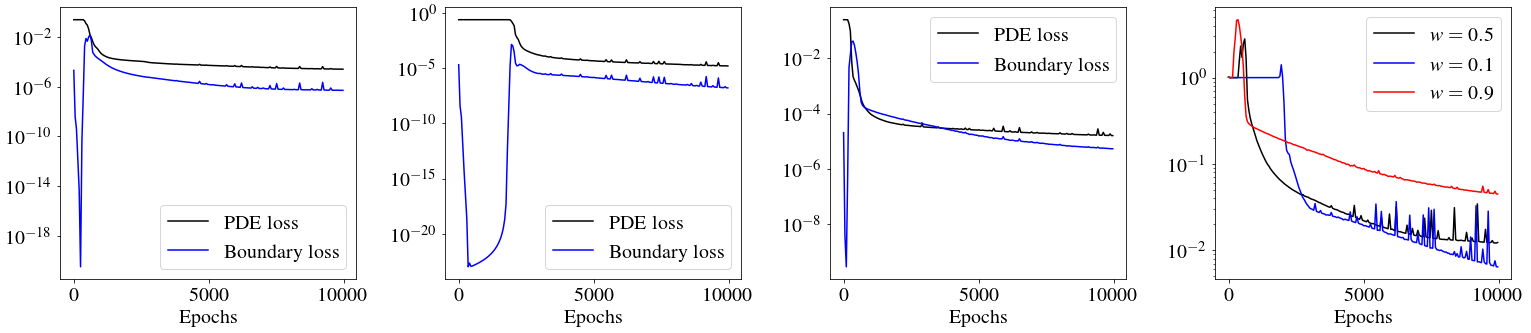

In [ ]:
#@title Study of boundary loss vs PDE loss as the weights of interior and boundary loss are changed 
k=1.
w=0.5

#Domain boundary
ax,bx = -1.,1.
ay,by = -1.,1.

numBatches = 1
num_epochs = 10000

numInt = 5000

#Interior
inputx = numpy.linspace(-.99, .99, num=70)
inputy = numpy.linspace(-.99, .99, num=70)
inputx, inputy = np.meshgrid(inputx, inputy)
inputx, inputy = inputx.flatten(), inputy.flatten()
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

#Boundary
#Interior square
p = numpy.array([[-1.,-1.],[1.,-1.],[1.,1.],[-1.,1.]])
segments = polygon(p,0)
geo = dmsh.Polygon(p)
X, cells = dmsh.generate(geo, 0.05)
# optionally optimize the mesh
X, cells = optimesh.optimize_points_cells(X, cells, "CVT (full)", 1.0e-10, 100)
mesh = meshplex.MeshTri(X, cells)

#Boundary points
Xb = X[mesh.is_boundary_point]
xb, yb = Xb[:,0], Xb[:,1]

#For plotting
# x = numpy.random.uniform(ax, bx,5000)
# y = numpy.random.uniform(ay, by,5000)
x = numpy.linspace(ax, bx, num=100)
y = numpy.linspace(ay, by, num=100)
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()


#NN
layer_sizes = [2, 50, 50, 1]

def f(x,y):
  return np.sin(k*np.pi*x)*np.sin(k*np.pi*y)

f_vect = vmap(f, (0, 0))

def exact(x,y):
  return (1/2.)*np.sin(k*np.pi*x)*np.sin(k*np.pi*y)/(k**2*np.pi**2)

e_vect = vmap(exact, (0, 0))


###################################
#No Dirichlet

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

numB = 100
input = np.linspace(-1., 1., num=numB)

def uNBC(params, x, y):
    return NN(params,x,y)

def lossNBC(params, x, y, w):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y) + f_vect(x,y)
    bdb = u_vect(params,input,-1.*np.ones(shape=(numB,)))
    bdt = u_vect(params,input,1.*np.ones(shape=(numB,)))
    bdl = u_vect(params,-1.*np.ones(shape=(numB,)),input)
    bdr = u_vect(params,1.*np.ones(shape=(numB,)),input)
    return w*np.mean(eq**2) + (1.-w)*(np.mean(bdb**2) + np.mean(bdt**2) + np.mean(bdr**2) + np.mean(bdl**2))/4

def lossNBC1(params, x, y, w):
    eq = d2udx2_vect(params, x, y) + d2udy2_vect(params, x, y) + f_vect(x,y)
    bdb = u_vect(params,input,-1.*np.ones(shape=(numB,)))
    bdt = u_vect(params,input,1.*np.ones(shape=(numB,)))
    bdl = u_vect(params,-1.*np.ones(shape=(numB,)),input)
    bdr = u_vect(params,1.*np.ones(shape=(numB,)),input)
    return np.mean(eq**2), (np.mean(bdb**2) + np.mean(bdt**2) + np.mean(bdr**2) + np.mean(bdl**2))/4


grad1 = grad(grad(uNBC,1),1)
grad2 = grad(grad(uNBC,2),2)
d2udx2_vect = vmap(grad1, (None, 0, 0))
d2udy2_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uNBC, (None, 0, 0))


def run_trainingNBC(num_epochs, opt_state, inputx, inputy, w, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    Ei = []
    Eb = []
    train_loss = []
    train_lossl1 = []
    train_lossl2 = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Eri, Erb, l1, l2 = updateNBC(params, x, y, opt_state, w)
        
      train_loss.append(loss)
      Ei.append(Eri)
      Eb.append(Erb)
      train_lossl1.append(l1)
      train_lossl2.append(l2)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, Ei, Eb, train_lossl1, train_lossl2

@jit
def updateNBC(params, x, y, opt_state, w):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossNBC)(params, x, y, w)
    opt_state = opt_update(0, grads, opt_state)
    Eri = error(params, x, y)
    Erb = error(params, xb, yb)
    l1, l2 = lossNBC1(params, x, y, w)
    return get_params(opt_state), opt_state, value, Eri, Erb, l1, l2
    
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)


train_loss, opt_state, ei, eb, l1, l2 = run_trainingNBC(num_epochs, opt_state, inputx, inputy, w, numBatches)

params = get_params(opt_state)

lossNBC1 = train_loss
loss1 = l1
loss2 = l2

##########################################################


plt.rcParams.update({'font.size': 20})
######
#Plots
fig = plt.figure(figsize=(26, 5))
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=.3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

e_dx = 50

ax1.plot(range(num_epochs)[::e_dx],loss1[::e_dx], color="black", label='PDE loss')
ax1.plot(range(num_epochs)[::e_dx],loss2[::e_dx], color="blue", label='Boundary loss')
# ax1.plot(range(num_epochs)[::e_dx],lossNBC1[::e_dx], color="green", label='MVP')
# ax1.plot(range(num_epochs)[::e_dx],l[::e_dx], color="red", label='MVP')
# ax1.plot(range(num_epochs)[::e_dx],lossNBC1[::e_dx], color="orange", label='$\\tilde{u}_{\mathrm{nn}}$')
# ax1.set_title('$w=0.5$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.legend(loc='best')

ax4.plot(range(num_epochs)[::e_dx],ei[::e_dx], color="black", label='$w=0.5$')
# ax4.plot(range(num_epochs)[::e_dx],ei[::e_dx], '+', color="black", label='$w=0.5$')
# ax4.set_title('Error')
ax4.set_yscale('log')
ax4.set_xlabel('Epochs')

params = initialize_mlp(layer_sizes, key)
w = 0.1
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, ei, eb, l1, l2 = run_trainingNBC(num_epochs, opt_state, inputx, inputy, w, numBatches)

params = get_params(opt_state)

lossNBC1 = train_loss
loss1 = l1
loss2 = l2
l = numpy.array(loss1) + numpy.array(loss2)

ax2.plot(range(num_epochs)[::e_dx],loss1[::e_dx], color="black", label='PDE loss')
ax2.plot(range(num_epochs)[::e_dx],loss2[::e_dx], color="blue", label='Boundary loss')
# ax2.set_title('$w=0.1$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.legend(loc='best')

ax4.plot(range(num_epochs)[::e_dx],ei[::e_dx], color="blue", label='$w=0.1$')
# ax4.plot(range(num_epochs)[::e_dx],ei[::e_dx], '+', color="blue", label='$w=0.1$')



params = initialize_mlp(layer_sizes, key)
w = 0.9
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, ei, eb, l1, l2 = run_trainingNBC(num_epochs, opt_state, inputx, inputy, w, numBatches)

params = get_params(opt_state)

lossNBC1 = train_loss
loss1 = l1
loss2 = l2
l = numpy.array(loss1) + numpy.array(loss2)

ax3.plot(range(num_epochs)[::e_dx],loss1[::e_dx], color="black", label='PDE loss')
ax3.plot(range(num_epochs)[::e_dx],loss2[::e_dx], color="blue", label='Boundary loss')
# ax3.set_title('$w=0.9$')
ax3.set_yscale('log')
ax3.set_xlabel('Epochs')
ax3.legend(loc='best')

ax4.plot(range(num_epochs)[::e_dx],ei[::e_dx], color="red", label='$w=0.9$')
# ax4.plot(range(num_epochs)[::e_dx],ei[::e_dx], '+', color="red", label='$w=0.9$')

ax4.legend(loc='best')




# # plt.tight_layout()
fig.savefig('HeatEq-LossMetric.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()
